In [2]:
import os
import cv2
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
from itertools import chain
from pathlib import Path
from skimage.io import imread, imshow
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Check for GPU and allocate a fixed amount of GPU mem
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)
else:
    print("WARNING: NO GPU FOUND")


In [53]:
base_path = Path('C://Users//Gabriel//Desktop//CS3244//PneumoniaCNN')

# Base file path for data
data_path = base_path / 'data' / 'pneumonia_data' / 'chest_xray_binary_covid'

# File path for training images
train_path = data_path / 'train'

# File path for testing images
test_path = data_path / 'test'


# RSNA Data
rsna_data_path = base_path / 'data' / 'rsna_data_scaled'

rsna_train_path = rsna_data_path / 'train'

# Covid Data
covid_data_path = base_path / 'data' / 'covid_pneumonia' / 'VALIDATION'

# Large Covid Data
covid_main_data_path = base_path / 'data' / 'covid_radiology' / 'train'

In [4]:
image_shape = (128, 128, 1)

batch_size = 16

Normal
Img Shape: (1010, 1462)


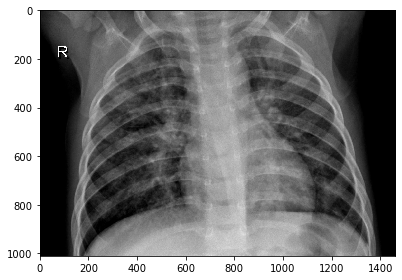

In [5]:
from skimage.exposure import equalize_adapthist, equalize_hist

def equalize_adaptivehist(image):
    return equalize_adapthist(image, clip_limit=0.03)

sample_image_path = test_path / 'PNEUMONIA' / 'person19_virus_50.jpeg'
sample_image = imread(sample_image_path)
enhanced_sample_image = equalize_hist(sample_image)

print("Normal")
print("Img Shape: " + str(sample_image.shape))
imshow(sample_image)

CLAHE
Img Shape: (1010, 1462)


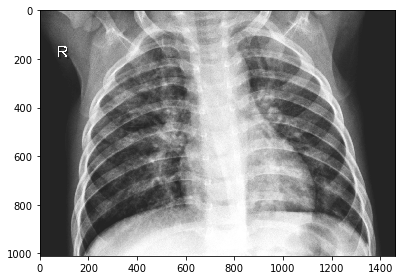

In [6]:
print("CLAHE")
print("Img Shape: " + str(enhanced_sample_image.shape))

imshow(enhanced_sample_image)

In [7]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2], # Vary brightness between range +-
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

In [8]:
rsna_image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255,
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2], # Vary brightness between range +-
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.2
                              )

In [9]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 5244 images belonging to 2 classes.
Found 638 images belonging to 2 classes.


In [10]:
rsna_train_image_gen = rsna_image_gen.flow_from_directory(rsna_train_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='training')

rsna_test_image_gen = rsna_image_gen.flow_from_directory(rsna_train_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='validation',
                                               shuffle=False)

Found 21348 images belonging to 2 classes.
Found 5336 images belonging to 2 classes.


In [11]:
covid_image_gen = image_gen.flow_from_directory(covid_data_path,
                                               target_size=image_shape[:2],
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 14 images belonging to 2 classes.


In [54]:
covid_train_image_gen = rsna_image_gen.flow_from_directory(covid_main_data_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='training')

covid_test_image_gen = rsna_image_gen.flow_from_directory(covid_main_data_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='validation',
                                               shuffle=False)

Found 2149 images belonging to 2 classes.
Found 537 images belonging to 2 classes.


In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dropout, Flatten, Dense, AlphaDropout
from tensorflow.keras.layers import Conv2D, SeparableConv2D, AveragePooling2D, DepthwiseConv2D,MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import binary_crossentropy, mean
from tensorflow.keras.layers import Multiply

In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras import backend as K

class printLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))
        
def weighted_binary_crossentropy(y_true, y_pred):
        weight_normal = 0.8
        weight_pneumonia = 1 - weight_normal
        b_ce = binary_crossentropy(y_true, y_pred)

        weight_vector = y_true * weight_pneumonia + (1. - y_true) * weight_normal
        weighted_b_ce = weight_vector * b_ce
        
        return mean(weighted_b_ce)
        
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [61]:
model_input = Input(shape=image_shape)

# Feature indentification and reduction
extraction_layer_1 = Conv2D(32, (3,3), activation='relu', padding='same')(model_input)
extraction_layer_1 = Conv2D(64, (3,3), activation='relu', padding='same')(extraction_layer_1)

f1 = Conv2D(96, (3,3), activation='relu', strides=(2,2), padding='same')(extraction_layer_1)

f2 = MaxPooling2D((3,3), strides=(2,2), padding='same')(extraction_layer_1)

reduction_layer_0 = concatenate([f1, f2])

z1 = Conv2D(64, (1,1), activation='relu')(reduction_layer_0)

z2 = Conv2D(32, (1,1), activation='relu')(reduction_layer_0)
z2 = Conv2D(48, (3,3), activation='relu', padding='same')(z2)

z3 = Conv2D(32, (1,1), activation='relu')(reduction_layer_0)
z3 = Conv2D(48, (5,5), activation='relu', padding='same')(z3)

inception_layer_0 = concatenate([z1,z2,z3])

a1 = Conv2D(128, (3,3), activation='relu', strides=(2,2), padding='same')(inception_layer_0)

a2 = MaxPooling2D((3,3), strides=(2,2), padding='same')(inception_layer_0)

reduction_layer_1 = concatenate([a1, a2])

d1 = Conv2D(64, (1,1), activation='relu')(reduction_layer_1)

d2 = Conv2D(64, (1,1), activation='relu')(reduction_layer_1)
d2 = Conv2D(128, (3,3), activation='relu', padding='same')(d2)

d3 = Conv2D(32, (1,1), activation='relu')(reduction_layer_1)
d3 = Conv2D(64, (5,5), activation='relu', padding='same')(d3)

inception_layer_1 = concatenate([d1,d2,d3])

# 2nd Reduction Layer
b1 = Conv2D(128, (3,3), activation='relu', strides=(2,2))(inception_layer_1)
b1 = BatchNormalization()(b1)

b2 = MaxPooling2D((3,3), strides=(2,2))(inception_layer_1)

reduction_layer_2 = concatenate([b1, b2])

x1 = Conv2D(128, (1,1), activation='relu')(reduction_layer_2)

x2 = Conv2D(32, (1,1), activation='relu')(reduction_layer_2)
x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(32, (1,1), activation='relu')(reduction_layer_2)
x3 = Conv2D(64, (5,5), activation='relu', padding='same')(x3)

inception_layer_2 = concatenate([x1, x2, x3])

c1 = Conv2D(160, (3,3), activation='relu', strides=(2,2))(inception_layer_2)
c1 = BatchNormalization()(c1)

c2 = MaxPooling2D((3,3), strides=(2,2))(inception_layer_2)

reduction_layer_3 = concatenate([c1, c2])

e1 = Conv2D(160, (1,1), activation='relu')(reduction_layer_3)
e1 = BatchNormalization()(e1)

e2 = Conv2D(96, (1,1), activation='relu')(reduction_layer_3)
e2 = Conv2D(160, (3,3), activation='relu', padding='same')(e2)
e2 = BatchNormalization()(e2)

e3 = Conv2D(64, (1,1), activation='relu')(reduction_layer_3)
e3 = Conv2D(128, (5,5), activation='relu', padding='same')(e3)
e3 = BatchNormalization()(e3)

inception_layer_3 = concatenate([e1,e2,e3])

model = AveragePooling2D((7, 7))(inception_layer_3)

model = Flatten()(model)

model = Dense(128, activation='relu')(model)

model = BatchNormalization()(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(inputs=model_input, outputs=model_output)


model.compile(loss=weighted_binary_crossentropy,
              optimizer='RMSProp',
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 128, 128, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 128, 128, 64) 18496       conv2d_156[0][0]                 
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 64, 64, 96)   55392       conv2d_157[0][0]                 
____________________________________________________________________________________________

In [63]:
results = model.fit(covid_train_image_gen,epochs=30,
                              validation_data=covid_test_image_gen,
                               callbacks=[ReduceLROnPlateau(), 
                                          ModelCheckpoint('checkpoint.h5',save_best_only=True, monitor='val_accuracy')])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 135 steps, validate for 34 steps
Epoch 1/30
135/135 [==============================] - 37s 275ms/step - loss: 0.2083 - accuracy: 0.7492 - val_loss: 0.2677 - val_accuracy: 0.4991
Epoch 2/30
135/135 [==============================] - 33s 244ms/step - loss: 0.1444 - accuracy: 0.8036 - val_loss: 13.7187 - val_accuracy: 0.5009
Epoch 3/30
135/135 [==============================] - 33s 241ms/step - loss: 0.1328 - accuracy: 0.8208 - val_loss: 0.1680 - val_accuracy: 0.6257
Epoch 4/30
135/135 [==============================] - 32s 240ms/step - loss: 0.1138 - accuracy: 0.8478 - val_loss: 9.6402 - val_accuracy: 0.5009
Epoch 5/30
135/135 [==============================] - 32s 236ms/step - loss: 0.1243 - accuracy: 0.8343 - val_loss: 2.2104 - val_accuracy: 0.5047
Epoch 6/30
135/135 [==============================] - 32s 236ms/step - loss: 0.1242 - accuracy: 0.8404 - val_loss: 16.1083 - val_accuracy: 0.5009
Epoch 7/30
135/135 [===============

In [64]:
model.save('curr_model.h5')

losses = pd.DataFrame(model.history.history)

In [78]:
from tensorflow.keras.models import load_model

def get_test_data(dataset):
    if dataset == 'rsna':
        return rsna_test_image_gen
    if dataset == 'original':
        return test_image_gen
    if dataset == 'covid':
        return covid_test_image_gen

def print_stats(model, dataset):
    testX = get_test_data(dataset)
    testY = testX.classes
    
    model.evaluate(testX)
    
    # Processing probabilities
    pred_probabilities = model.predict(testX)
    predictions = pred_probabilities > 0.5
    
    for i in range(len(pred_probabilities)):
        if pred_probabilities[i] > 0.7:
            pred_probabilities[i] = 2
        elif pred_probabilities[i] > 0.3:
            pred_probabilities[i] = 1
        else:
            pred_probabilities[i] = 0
    
    # Only for binary classification
    print(classification_report(testY, predictions))
    
    # Print Confusion Matrix
    cm  = confusion_matrix(testY, pred_probabilities)[:-1]
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(3), ['Normal', 'Unsure', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.show()

  ...
    to  
  ['...']
34/34 [==============================] - 6s 187ms/step - loss: 0.0819 - accuracy: 0.9516
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       268
           1       0.93      0.93      0.93       269

    accuracy                           0.93       537
   macro avg       0.93      0.93      0.93       537
weighted avg       0.93      0.93      0.93       537



<Figure size 432x288 with 0 Axes>

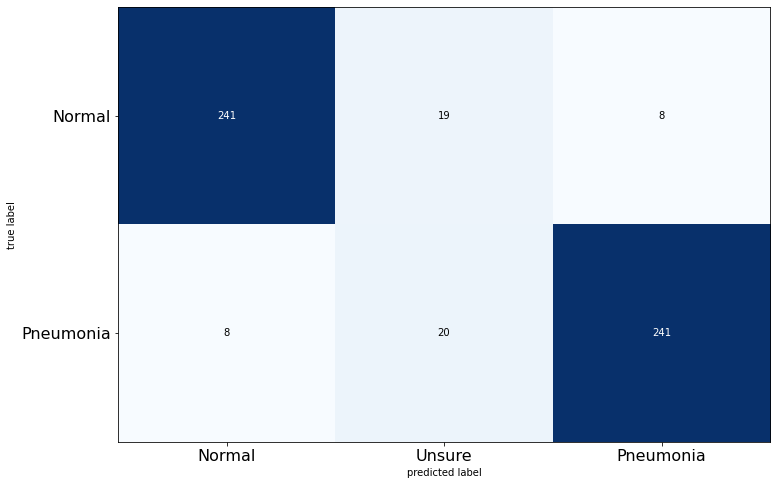

  ...
    to  
  ['...']
40/40 [==============================] - 6s 146ms/step - loss: 0.3860 - accuracy: 0.8056
              precision    recall  f1-score   support

           0       0.89      0.53      0.67       234
           1       0.78      0.96      0.86       404

    accuracy                           0.81       638
   macro avg       0.84      0.75      0.77       638
weighted avg       0.82      0.81      0.79       638



<Figure size 432x288 with 0 Axes>

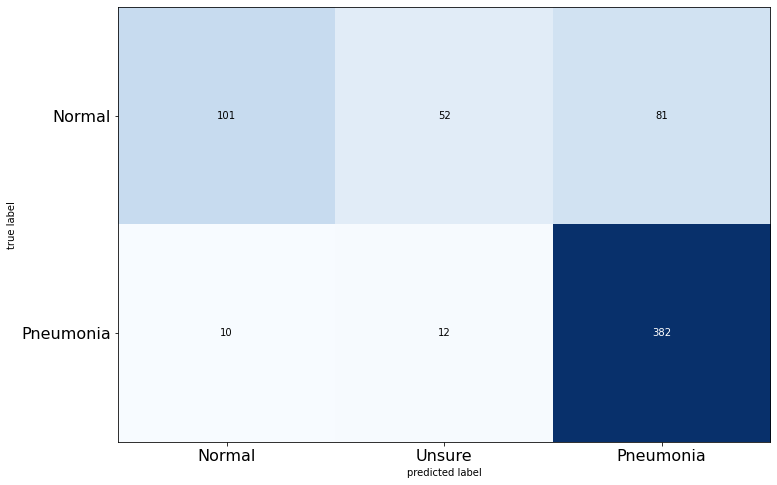

In [79]:
best_model = load_model('checkpoint.h5'
                        , custom_objects={'weighted_binary_crossentropy':weighted_binary_crossentropy}
                       )

print_stats(best_model, 'covid')
print_stats(best_model, 'original')

  ...
    to  
  ['...']
34/34 [==============================] - 6s 191ms/step - loss: 0.0889 - accuracy: 0.9385
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       268
           1       0.93      0.94      0.94       269

    accuracy                           0.93       537
   macro avg       0.93      0.93      0.93       537
weighted avg       0.93      0.93      0.93       537



<Figure size 432x288 with 0 Axes>

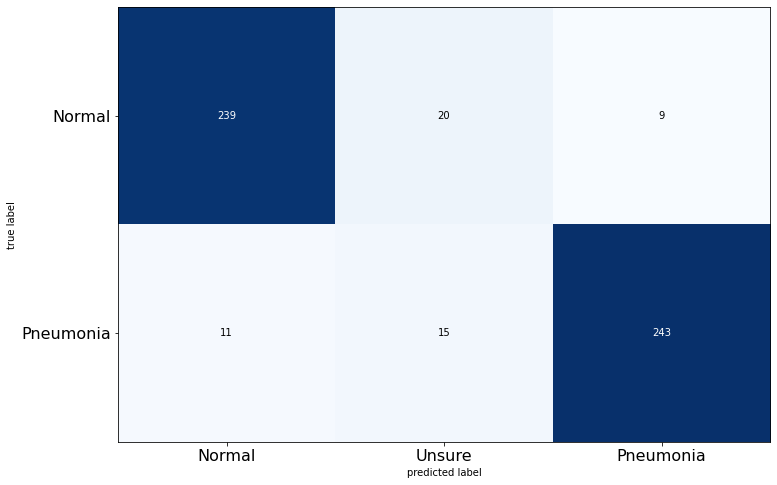

  ...
    to  
  ['...']
40/40 [==============================] - 6s 146ms/step - loss: 0.3761 - accuracy: 0.8166
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       234
           1       0.79      0.97      0.87       404

    accuracy                           0.82       638
   macro avg       0.85      0.76      0.78       638
weighted avg       0.84      0.82      0.80       638



<Figure size 432x288 with 0 Axes>

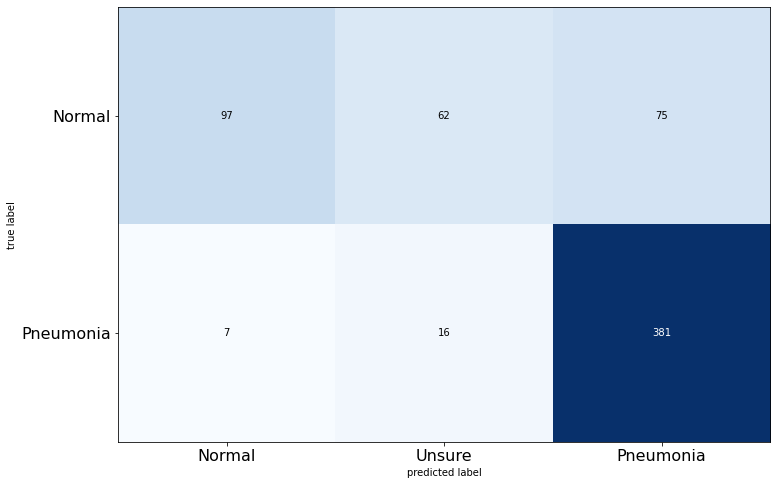

In [80]:
curr_model = load_model('curr_model.h5'
                        , custom_objects={'weighted_binary_crossentropy':weighted_binary_crossentropy}
                       )

print_stats(curr_model, 'covid')
print_stats(curr_model, 'original')

In [68]:
best_predictions = best_model.predict(covid_image_gen)
curr_predictions = curr_model.predict(covid_image_gen)

In [76]:
best_predictions = best_predictions > 0.5
curr_predictions = curr_predictions > 0.5

In [77]:
print(best_predictions)
print(curr_predictions)

[[False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]]
[[False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]]


In [70]:
sample_image_path_1 = test_path / 'NORMAL' / 'NORMAL2-IM-0285-0001.jpeg'
sample_image_path_2 = test_path / 'NORMAL' / 'NORMAL2-IM-0378-0001.jpeg'
sample_image_path_3 = test_path / 'NORMAL' / 'NORMAL2-IM-0332-0001.jpeg'
sample_image_path_4 = test_path / 'PNEUMONIA' / 'person109_bacteria_528.jpeg'
sample_image_path_5 = test_path / 'PNEUMONIA' / 'person1675_virus_2891.jpeg'
sample_image_path_6 = test_path / 'PNEUMONIA' / 'person96_bacteria_465.jpeg'

In [71]:
import scipy
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import sys

In [72]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return x

def get_ResNet():
    # define ResNet50 model
    model = load_model('checkpoint_archive.h5', custom_objects={'weighted_binary_crossentropy':weighted_binary_crossentropy})
    
    # get AMP layer weights
    conv_weights = model.layers[-3].get_weights()[0]
    
    dense_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
                         outputs=[model.layers[-6].output, model.layers[-3].output, model.layers[-1].output])
    return ResNet_model, conv_weights, dense_weights
    
def ResNet_CAM(img_path, model, conv_weights, dense_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec, prediction = model.predict(pretrained_path_to_tensor(img_path))
    # change dimensions of last convolutional outpu tto 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output) 
    # bilinear upsampling to resize each filtered image to size of original image
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (18, 18, 1), order=1) # dim: 224 x 224 x 2048

    
    if prediction > 0.5:
        prediction = 1
    else:
        prediction = 0

#     # get AMP layer weights
#     dense_weights = dense_weights[:, prediction] # dim: (2048,) 
    
    first_output = np.dot(conv_weights, dense_weights)

    
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((126*126, 448)), first_output).reshape(126,126) # dim: 224 x 224
    # return class activation map
    return final_output, prediction
    
def plot_ResNet_CAM(img_path, ax, model, conv_weights, dense_weights):
    
    im = load_img(img_path, target_size=(126, 126), color_mode='grayscale')
    
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(im, alpha=0.5, cmap='gray', vmin=0, vmax=255)
    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, conv_weights, dense_weights)
    # plot class activation map
    ax[1].imshow(CAM, cmap='jet', alpha=0.5)

    if pred == 1:
        classification = 'Pneumonia'
    else:
        classification = 'Normal'
    ax[1].set_title("Classified: %s" % (classification))

ResNet_model, conv_weights, dense_weights = get_ResNet()

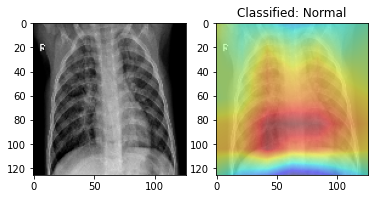

In [73]:
fig, ax = plt.subplots(1,2)
CAM = plot_ResNet_CAM(sample_image_path, ax, ResNet_model, conv_weights, dense_weights)
plt.show()

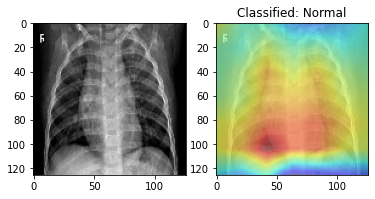

In [74]:
fig, ax = plt.subplots(1,2)
CAM = plot_ResNet_CAM(sample_image_path_1, ax, ResNet_model, conv_weights, dense_weights)
plt.show()

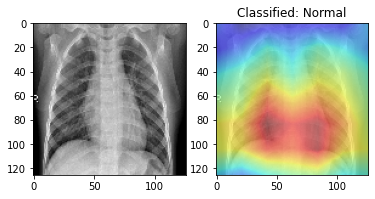

In [75]:
fig, ax = plt.subplots(1,2)
CAM = plot_ResNet_CAM(sample_image_path_3, ax, ResNet_model, conv_weights, dense_weights)
plt.show()